# DATA CLEANING

In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## Standardize City Names

In [218]:
# Load merged data
df = pd.read_csv('retail_orders.csv')
print(df.head())

   customer_id first_name last_name  age      city loyalty_status signup_date  \
0            1      Harry       Doe   39   Chicago        Regular  2024-03-05   
1            1      Harry       Doe   39   Chicago        Regular  2024-03-05   
2            2        Tom   Johnson   33  NEW YORK        Regular  2024-10-13   
3            2        Tom   Johnson   33  NEW YORK        Regular  2024-10-13   
4            2        Tom   Johnson   33  NEW YORK        Regular  2024-10-13   

   order_id  order_date  total_amount  quantity  discount_applied  \
0      1578  2025-03-13       1287.98         2               0.0   
1       449  2025-03-27        352.74         3               0.0   
2      1973  2025-02-27        165.81         1               0.0   
3      1410  2025-03-05       5849.76         4               0.0   
4      1252  2025-03-28       3672.27         3               0.0   

  product_name     category    price  
0        Dress     Clothing   643.99  
1     Keyboard     C

There appears to be a problem with the letter casing in the city column. We will standardize the city names by applying the str.title() method, ensuring all entries follow a uniform format. str.title() is a string method that converts the first character of each word in a string to uppercase and the rest to lowercase.

In [220]:
# Standardize the city names
df['city'] = df['city'].str.strip().str.title()

## Fix Invalid Ages

In [222]:
print(df.describe())

       customer_id          age     order_id  total_amount     quantity  \
count  1000.000000  1000.000000  1000.000000   1000.000000  1000.000000   
mean    182.673000    35.073000  1462.807000   1403.249550     1.849000   
std     105.868845    15.387672   796.137914   1274.467409     1.133792   
min       1.000000    -5.000000   102.000000     44.540000     1.000000   
25%      93.000000    28.000000   749.250000    519.100000     1.000000   
50%     180.000000    35.000000  1481.500000   1063.155000     1.000000   
75%     277.250000    41.000000  2150.000000   1921.602500     2.000000   
max     369.000000   150.000000  2818.000000   7472.700000     5.000000   

       discount_applied        price  
count       1000.000000  1000.000000  
mean           0.041200   791.137450  
std            0.072442   445.230466  
min            0.000000    55.670000  
25%            0.000000   336.630000  
50%            0.000000   837.490000  
75%            0.100000  1116.630000  
max         

The results show negative values and unrealistic entries, such as ages of 150, in the 'age' column. We fix them by replacing with null if there are negative and replacing with 80 if they are above 80. Aftering the fix, the minimum age becomes 14 while the maximum age is 80.

In [224]:
# Fix invalid ages 
df['age'] = df['age'].apply(lambda x: np.nan if pd.isna(x) or x < 0 else min(x, 80))

## Handle Missing Values and Duplicates

In [226]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       1000 non-null   int64  
 1   first_name        1000 non-null   object 
 2   last_name         931 non-null    object 
 3   age               983 non-null    float64
 4   city              1000 non-null   object 
 5   loyalty_status    1000 non-null   object 
 6   signup_date       1000 non-null   object 
 7   order_id          1000 non-null   int64  
 8   order_date        1000 non-null   object 
 9   total_amount      1000 non-null   float64
 10  quantity          1000 non-null   int64  
 11  discount_applied  1000 non-null   float64
 12  product_name      1000 non-null   object 
 13  category          1000 non-null   object 
 14  price             1000 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 117.3+ KB
None


There are some missing values in 'last_name' and 'age' columns. We will also check for duplicates at the same time.

In [228]:
# Drop rows where any values are missing
df = df.dropna()
# Check for duplicate rows
print(f'Number of duplicates: {df.duplicated().sum()}')
print(df.info())

Number of duplicates: 0
<class 'pandas.core.frame.DataFrame'>
Index: 914 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       914 non-null    int64  
 1   first_name        914 non-null    object 
 2   last_name         914 non-null    object 
 3   age               914 non-null    float64
 4   city              914 non-null    object 
 5   loyalty_status    914 non-null    object 
 6   signup_date       914 non-null    object 
 7   order_id          914 non-null    int64  
 8   order_date        914 non-null    object 
 9   total_amount      914 non-null    float64
 10  quantity          914 non-null    int64  
 11  discount_applied  914 non-null    float64
 12  product_name      914 non-null    object 
 13  category          914 non-null    object 
 14  price             914 non-null    float64
dtypes: float64(4), int64(3), object(8)
memory usage: 114.2+ KB
None


## Convert Data Type
It is also observed that 'signup_date' and 'order_date' are object data type. As they are time information, we will convert them to datetime data type.

In [230]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['order_date'] = pd.to_datetime(df['order_date'])

# HYPOTHESIS TESTING
In this analysis, we aim to evaluate whether there is a significant difference in spending behavior among customers with different loyalty statuses. Specifically, we focus on three distinct levels of customer loyalty of Regular, Silver, and Gold, with Gold representing the highest level of loyalty.

Our primary objective is to determine whether Gold-level customers spend more on average than Regular-level customers. This can provide valuable insights into the effectiveness and impact of loyalty programs on customer spending patterns. By identifying statistically significant differences in spending behavior, businesses can better tailor their marketing strategies, rewards, and customer retention efforts. To investigate this, we will perform a a t-testcomparing total_amount between loyalty_status groups.

<b>Null Hypothesis</b>: There is no difference in the average spending between Gold and Regular customers.

<b>Alternative Hypothesis</b>: Gold customers spend more on average than Regular customers.

In [232]:
# Compare spending between two groups
gold_spending = df[df['loyalty_status'] == 'Gold']['total_amount']
regular_spending = df[df['loyalty_status'] == 'Regular']['total_amount']

# Perform t-test
t_stat, p_value = ttest_ind(gold_spending, regular_spending, equal_var=False)
print("T-test p-value:", p_value)
if p_value < 0.05:
    print("Reject null hypothesis.")
else:
    print("Fail to reject null hypothesis.")

T-test p-value: 0.8301442423815897
Fail to reject null hypothesis.


The p-value of 0.821 suggests that there is no statistically significant difference in the average spending between Gold and Regular customers. This high p-value indicates that the observed difference in spending is likely due to random variation, and not due to any real effect of loyalty status. As a result, we fail to reject the null hypothesis, concluding that there is insufficient evidence to support the claim that Gold customers spend more on average than Regular customers.

# CORRELATION ANALYSIS
The Pearson correlation coefficient was calculated to analyze the relationships between key numerical variables—age, total_amount, quantity, and discount_applied. The results were then visualized using a heatmap. This analysis helps in understanding the underlying structure of the data and in identifying which features may be more influential or interdependent when building predictive models.

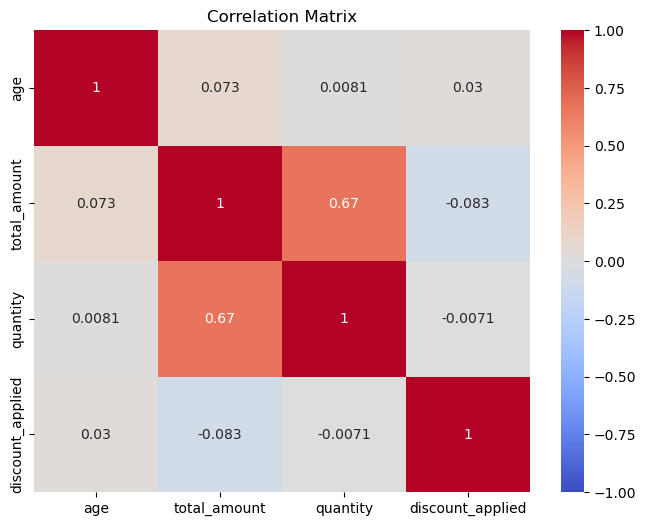

In [24]:
# Select numerical columns
corr_columns = ['age', 'total_amount', 'quantity', 'discount_applied']
corr_matrix = df[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Among all the features, the only notable correlation observed is between total_amount and quantity, with a correlation coefficient of 0.67, indicating a moderate to strong positive linear relationship. All other feature pairs show either weak or negligible correlations, suggesting they do not exhibit strong linear dependencies. This suggests that most features are not similar to each other (not highly correlated) and it helps most machine learning models make better decisions because each feature gives new and distinct information. 

# PREDICTION OF CUSTOMER CHURN RATE
A predictive model has been developed to estimate the customer churn rate, specifically identifying customers who are unlikely to make a purchase again. The goal of this model is to help the business proactively address potential churn by understanding patterns in customer behavior. The Random Forest algorithm was chosen for this task due to its ability to handle both categorical and numerical features, its robustness against overfitting, and its effectiveness in capturing non-linear relationships in the data. 

To build the model, a range of customer-related features were utilized, including:
customer_id: Unique identifier for each customer </br>
age: Age of the customer </br>
loyalty_status: Loyalty level (e.g., Regular, Silver, Gold) </br>
city: Customer’s location </br>
tenure: Duration of the customer relationship </br>
avg_order_amount: Average amount spent per order </br>
order_count: Total number of past orders </br>
discount_applied: Indicator of whether discounts were used </br>
category: Product category most frequently purchased </br>

In this predictive modeling task, the churn rate is defined based on customer purchasing behavior relative to a specific cutoff date — April 10, 2025. The outputs include 'actual_churn' (based on whether a purchase was made since the cutoff date), 'predicted churn', and a probability score indicating the model's estimated likelihood that a customer will churn. The output values are encoded as 1 for churned customers (those who did not make a purchase since the cutoff date) and 0 for active customers (those who continued to make purchases). In addition to these labels, the model also provides a probability score representing the predicted likelihood of churn for each customer. Additionally, the overall accuracy of the model is displayed.

In [234]:
# Feature engineering
df['tenure'] = (pd.to_datetime('2025-04-01') - pd.to_datetime(df['signup_date'])).dt.days

# Compute order summary stats
order_summary = df.groupby('customer_id').agg(avg_order_amount=('total_amount', 'mean'), order_count=('order_id', 'count')).reset_index()

# Merge with original DataFrame (ensure 'customer_id' is the key)
df = df.merge(order_summary, on='customer_id', how='left') 

In [236]:
# Define churn (no orders in last 30 days)
last_order = df.groupby('customer_id')['order_date'].max()
df['churn'] = df['customer_id'].map(lambda x: 1 if (pd.to_datetime('2025-04-01') - last_order[x]).days > 30 else 0)

# Encode categorical variables
le = LabelEncoder()
df['loyalty_status'] = le.fit_transform(df['loyalty_status'])
df['city'] = le.fit_transform(df['city'])
df['category'] = le.fit_transform(df['category'])

# Features and target
df = df.drop_duplicates(subset='customer_id')
features = ['customer_id', 'age', 'loyalty_status', 'city', 'tenure', 'avg_order_amount', 'order_count', 'discount_applied', 'category']
X = df[features]
y = df['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train.drop('customer_id', axis=1), y_train)

# Get hard predictions (0 or 1)
y_pred_proba = model.predict_proba(X_test.drop('customer_id', axis=1))[:, 1]  
y_pred = model.predict(X_test.drop('customer_id', axis=1))  

# Add results into a dataset
results = X_test[['customer_id']].copy()
results['actual_churn'] = y_test.values
results['predicted_churn'] = y_pred
results['churn_probability'] = y_pred_proba

# Evaluate accuracy
print("Accuracy:", model.score(X_test.drop('customer_id', axis=1), y_test))

print(results[['customer_id', 'actual_churn', 'predicted_churn', 'churn_probability']].to_string(index=False))

Accuracy: 0.6907216494845361
 customer_id  actual_churn  predicted_churn  churn_probability
         202             1                0               0.41
         158             0                1               0.66
         230             1                1               0.70
          10             0                0               0.06
         126             0                1               0.52
         143             0                0               0.13
         292             0                0               0.39
         186             0                1               0.69
         265             1                1               0.67
         356             1                1               0.62
         229             1                1               0.65
         108             0                0               0.20
         321             0                0               0.15
         102             0                0               0.09
         218             1

The model achieved an accuracy of approximately 70%, indicating that it correctly predicts customer churn in about seven out of ten cases. While this level of accuracy demonstrates a solid predictive capability, there may still be room for improvement.